1.) Installing requirements

In [ ]:
import sys; print(sys.executable) #verifying path of Python Interpreter


c:\Users\franc\anaconda3\envs\nlp-project\python.exe


In [2]:
import sys, torch, sklearn, transformers
print(sys.executable)                 # should show ...\envs\nlp-project\python.exe
print("torch:", torch.__version__)
print("sklearn:", sklearn.__version__)
print("transformers:", transformers.__version__)


c:\Users\franc\anaconda3\envs\nlp-project\python.exe
torch: 2.3.1
sklearn: 1.7.1
transformers: 4.55.2


In [ ]:
!pip install transformers #import model and tokenizer library


In [ ]:
!pip install datasets #import dataset handling

In [5]:
!pip install --upgrade pandas

In [ ]:
! pip install evaluate #import metrics package used with Hugging Face to evaluate model

In [ ]:
##Configs
#make so that any changes to the data set or model can be done here
data_path = "data.csv" #@param {type:"string"} parametrize the dataset path so if the dataset changes, I just have to update here
text_column_name = "text" #@param {type:"string"}
label_column_name = "label" #@param {type:"string"}

model_name = "distilbert-base-uncased" #@param {type:"string"} using distilBert model from hugging face library for binary classification
test_size = 0.2 #@param {type:"number"} reserve 20% data for test
num_labels = 2 #@param {type:"number"} telling model how many classes i have

2.) Read and Prepare the dataset

In [ ]:
#core data and math imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv("data.csv") #load csv into pandas df
df.head()

,id,label,text
0,1_0,0,find out more here
1,2_0,0,i had a long battle with anorexia
2,3_0,0,those thoughts telling me that if i just lost...
3,4_0,0,the trouble is that never happened
4,5_0,0,there was never a magic number


In [10]:
# Count occurrences of each label
label_counts = df['label'].value_counts()

print(label_counts)


label
1    2135
0    1234
Name: count, dtype: int64


In [ ]:
# Shuffle the entire dataframe for an even distribution of 0s and 1s for training and testing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,id,label,text
0,1972_1,1,never drink more than two gallons of water a day
1,950_0,0,"additionally, if you're currently in a positi..."
2,1226_1,1,5 avoid oil and butter3
3,140_0,0,your information has been submitted
4,300_0,0,you may be used to skipping meals or fasting ...


In [12]:
from sklearn.model_selection import train_test_split

In [ ]:
df_train,df_test = train_test_split(df,test_size=test_size) #splitting df into 80% train and 20% split

In [ ]:
##Convert to hugging face dataset
from datasets import Dataset
#making the df compatible w hugging face tools
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

In [ ]:
##Tokenize the text (mapping chunk of text to number so that model can understand)
from transformers import AutoTokenizer #turns raw text into token IDS so that model can understand

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name) #fetching the correct tokenizer that matches with DistilBERT model

def preprocess_function(examples): #function that returns the text as tokens
    return tokenizer(examples["text"], truncation=True)

In [ ]:
tokenized_train = train_dataset.map(preprocess_function, batched=True) #applying tokenizing "Preprocess" function in batches

Map:   0%|          | 0/2695 [00:00<?, ? examples/s]

In [ ]:
tokenized_test = test_dataset.map(preprocess_function, batched=True) #applying tokenizing function to test batch


Map:   0%|          | 0/674 [00:00<?, ? examples/s]

In [19]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # should be False for CPU-only, that's fine


2.3.1
False


3.) Initialize the model

In [20]:
##Initializing model
import transformers
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

In [ ]:
##load AutoModelForSequenceClassification which is a pretrained DistilBERT model with a classification head configured for binary classification.
#allows for fine-tuning a model instead of training from scratch
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


4.) Training the model

In [ ]:
#Training the model
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) #assembles/formats data for training

In [ ]:
metric = evaluate.load("accuracy") #using accuracy metric from HF to evaluate

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results", #Directory path where model checkpoints, logs, and training artifacts are saved
    learning_rate=2e-4, #Step size for gradient descent optimization; controls how much model weights are updated each iteration
    per_device_train_batch_size=8, #Number of training samples processed together in one forward/backward pass before updating weights
    per_device_eval_batch_size=8, 
    num_train_epochs=5, #Complete passes through the entire training dataset (iterations)
    weight_decay=0.01,  #L2 regularization parameter that penalizes large weights to prevent overfitting
    logging_strategy="epoch",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics

)


C:\Users\franc\AppData\Local\Temp\ipykernel_2592\3541624526.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [25]:
trainer.train()

Step,Training Loss
337,0.526200
674,0.444500
1011,0.396600
1348,0.276800
1685,0.200100


TrainOutput(global_step=1685, training_loss=0.36885829665186853, metrics={'train_runtime': 3665.6991, 'train_samples_per_second': 3.676, 'train_steps_per_second': 0.46, 'total_flos': 159896688115596.0, 'train_loss': 0.36885829665186853, 'epoch': 5.0})

In [30]:
#saving the model
trainer.save_model('ED_model')

5.) Evaluate the model's performance

In [ ]:
#Evaluate model performance
from sklearn.metrics import classification_report #Imports scikit-learn’s function that prints precision, recall, f1-score, and support

In [ ]:
#evaluating performance on training data to test for overfitting
preds = trainer.predict(tokenized_train)
preds = np.argmax(preds[:3][0],axis=1)
GT = df_train['label'].tolist() #Extracts the ground-truth labels from your original training DataFrame as a list
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       993
           1       0.96      0.98      0.97      1702

    accuracy                           0.96      2695
   macro avg       0.96      0.95      0.96      2695
weighted avg       0.96      0.96      0.96      2695



In [ ]:
#evaluating model performance on test data (data never seen by model before)
preds = trainer.predict(tokenized_test)
preds = np.argmax(preds[:3][0],axis=1) #preds[:3][1]
GT = df_test['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       241
           1       0.91      0.89      0.90       433

    accuracy                           0.87       674
   macro avg       0.85      0.86      0.86       674
weighted avg       0.87      0.87      0.87       674



In [ ]:
#when comparing model performance to test data
#Precision score for class 1 was 0.91- means model flagged pro-ana text 91% of the time
#Recall score for class 1 was 0.89- means almost 9/10 times, the model catches pro-ana text
#f1 score that balances precision and recall
#support means that out of the training data, there were x amt of 0s classified, or x amt of 1s classified

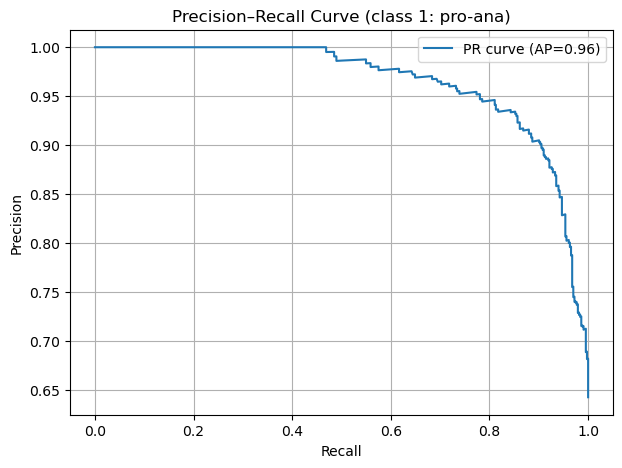

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from scipy.special import softmax
import numpy as np

# 1) Get raw predictions (logits) on the test set
output = trainer.predict(tokenized_test)
logits = output.predictions
labels = output.label_ids

# 2) Convert logits → probabilities for class 1 (pro-ana)
probs = softmax(logits, axis=1)[:, 1]

# 3) Compute precision–recall curve
precision, recall, thresholds = precision_recall_curve(labels, probs)
avg_prec = average_precision_score(labels, probs)

# 4) Plot
plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f"PR curve (AP={avg_prec:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (class 1: pro-ana)")
plt.legend()
plt.grid(True)
plt.show()
